In [2]:
# Generate a prescription for the surface correction from ensemble modelling
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
import os
import sys
import h5py
# import asteroseismology as se
from astropy.io import ascii
from astropy.table import Table
# import corner
# import scipy
from multiprocessing import Pool
# import emcee
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
from multiprocessing import get_context, Pool
from scipy.optimize import curve_fit
# from grid import grid #, match_modes

rootpath = os.getenv('WORK_DIR')+'numax-amlt/'
rootpath = '/Users/yaguang/My Drive/numax-amlt/'
sys.path.append(rootpath)
work_dir = rootpath+'numax/'

In [3]:
stars = pd.read_csv('../sample/samples_rg.csv')
idx = stars.index>=0 #((stars['ifmodelling']==1) & (stars['numax']>0) &  (stars['Dnu']>2) &
       #(stars['[M/H]']>-3.) & (stars['Teff']>0) & (stars['lum_J']>0) 
    
stars = stars.loc[idx,:].reset_index(drop=True)
modes = pd.read_csv('../sample/modes_rg.csv')

In [4]:
stars.head()

,KIC,Teff_spec,e_Teff_spec,[M/H],e_[M/H],Dnu,e_Dnu,ra,ra_error,dec,...,phot_g_mean_mag_corr,logg,Teff,e_Teff,luminosity,e_luminosity,numax_yu,e_numax_yu,numax,e_numax
0,1027337,4635.5390,100,0.231188,0.06,6.937,0.014,291.334197,0.009558,36.786600,...,12.040522,2.770453,4633,100,27.253188,1.440431,74.21,0.68,73.239252,0.611628
1,1163359,4578.9840,100,-0.413422,0.06,2.642,0.015,291.493292,0.010812,36.848781,...,11.984016,2.228348,4585,100,89.660979,7.896483,21.43,0.41,21.169614,0.274593
2,1294122,4805.9585,100,-0.054198,0.06,7.022,0.016,291.279893,0.007021,36.906973,...,11.905418,2.786468,4759,100,27.669848,1.224867,75.62,0.84,73.861258,0.634862
3,1294385,4823.5620,100,0.079879,0.06,9.090,0.016,291.339543,0.008559,36.902718,...,10.624201,2.937237,4818,100,20.791524,0.735736,106.81,1.08,104.409957,0.905508
4,1296068,4586.5454,100,-0.010170,0.06,6.140,0.013,291.686720,0.008105,36.970840,...,12.800625,2.672638,4510,100,23.087333,1.313684,59.56,0.49,58.526741,0.357770


# Get systematic uncertainties for the models

In [5]:
def multi(inputs):
    istar, star = inputs
    filepath = '../results_gaia_nu/{:0.0f}/data.h5'.format(star['KIC'])
    if not os.path.exists(filepath): return [np.nan, np.nan, np.nan]
    f = h5py.File(filepath,'r')

    idx = (modes['KIC']==star['KIC']) 
    tm = modes.loc[idx,:].reset_index(drop=True)
    
    idx = np.argmin(f['chi2_seismic_l0'][:])
    mod_freq = f['mod_freq_sc'][idx, (tm['l']==0).to_numpy()]
    obs_freq = tm.loc[tm['l']==0,'fc'].to_numpy()
    rms_l0 = np.sqrt(np.mean((mod_freq - obs_freq)**2))
    
    idx = np.argmin(f['chi2_seismic_l2'][:])
    mod_freq = f['mod_freq_sc'][idx, (tm['l']==2).to_numpy()]
    obs_freq = tm.loc[tm['l']==2,'fc'].to_numpy()
    rms_l2 = np.sqrt(np.mean((mod_freq - obs_freq)**2))
    
    idx = np.argmin(f['chi2_seismic'][:])
    mod_freq = f['mod_freq_sc'][idx, :]
    obs_freq = tm.loc[: ,'fc'].to_numpy()
    rms = np.sqrt(np.mean((mod_freq - obs_freq)**2))
    
    return [rms_l0, rms_l2, rms]

# r=process_map(multi, stars.iterrows(), total=len(stars), max_workers=12)

r = list(tqdm(get_context("fork").Pool(8).imap(multi, stars.loc[:].iterrows()), total=len(stars), position=0))
stars.loc[:, ['rms_l0', 'rms_l2', 'rms']]  = np.array(r)

100%|██████████| 2785/2785 [00:00<00:00, 3833.76it/s]


In [6]:
stars

,KIC,Teff_spec,e_Teff_spec,[M/H],e_[M/H],Dnu,e_Dnu,ra,ra_error,dec,...,e_Teff,luminosity,e_luminosity,numax_yu,e_numax_yu,numax,e_numax,rms_l0,rms_l2,rms
0,1027337,4635.5390,100,0.231188,0.06,6.937,0.014,291.334197,0.009558,36.786600,...,100,27.253188,1.440431,74.21,0.68,73.239252,0.611628,NaN,NaN,NaN
1,1163359,4578.9840,100,-0.413422,0.06,2.642,0.015,291.493292,0.010812,36.848781,...,100,89.660979,7.896483,21.43,0.41,21.169614,0.274593,0.029987,0.036316,0.034267
2,1294122,4805.9585,100,-0.054198,0.06,7.022,0.016,291.279893,0.007021,36.906973,...,100,27.669848,1.224867,75.62,0.84,73.861258,0.634862,NaN,NaN,NaN
3,1294385,4823.5620,100,0.079879,0.06,9.090,0.016,291.339543,0.008559,36.902718,...,100,20.791524,0.735736,106.81,1.08,104.409957,0.905508,NaN,NaN,NaN
4,1296068,4586.5454,100,-0.010170,0.06,6.140,0.013,291.686720,0.008105,36.970840,...,100,23.087333,1.313684,59.56,0.49,58.526741,0.357770,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2780,12647227,4790.0854,100,-0.460332,0.06,4.342,0.016,290.559287,0.009886,51.780824,...,100,51.209177,1.878490,38.70,0.58,38.086791,0.371699,NaN,NaN,NaN
2781,12647352,4524.1772,100,-0.408592,0.06,2.755,0.016,290.621462,0.008077,51.721204,...,100,84.951597,5.261892,22.75,0.30,22.111021,0.186848,NaN,NaN,NaN
2782,12735851,4688.1720,100,-0.305272,0.06,4.774,0.012,289.833822,0.009257,51.976219,...,100,39.142495,2.214438,42.71,0.55,42.192120,0.333087,0.009759,0.018769,0.012281
2783,12785250,4773.4170,100,-0.374362,0.06,3.857,0.015,290.448639,0.009792,52.093476,...,100,66.922540,6.021725,33.72,0.37,32.650622,0.263937,0.010498,0.039103,0.029437


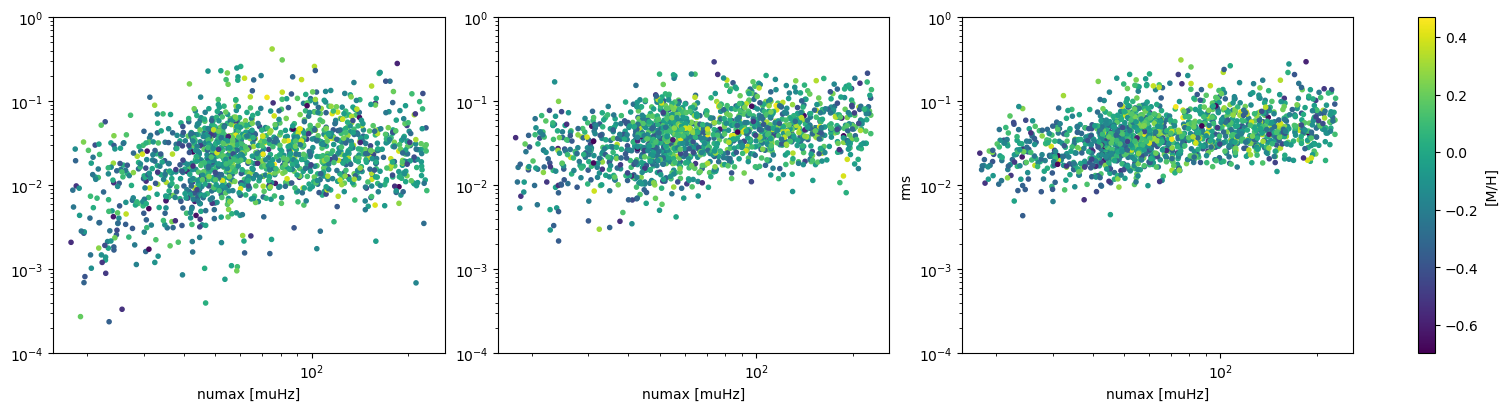

In [7]:
fig, axes = plt.subplots(figsize=[15,4], nrows=1, ncols=3, squeeze=False, constrained_layout=True)
axes = axes.reshape(-1)

axes[0].scatter(stars['numax'], stars['rms_l0'], marker='.', c=stars['[M/H]'])
             
axes[1].scatter(stars['numax'], stars['rms_l2'], marker='.', c=stars['[M/H]'])

c=axes[2].scatter(stars['numax'], stars['rms'], marker='.', c=stars['[M/H]'])

for iax in range(3):
    axes[iax].set_yscale('log')
    axes[iax].set_xscale('log')
    axes[iax].set_xlabel('numax [muHz]')
    axes[iax].set_ylim(10.**-4, 10.**0)
axes[iax].set_ylabel('rms_l0')
axes[iax].set_ylabel('rms_l2')
axes[iax].set_ylabel('rms')
plt.colorbar(c, ax=axes).set_label('[M/H]')

Because the rms values of l=0 and l=2 modes do not show large differences, I use the rms of all modes to characterise the systematic uncertainties of stellar models.

In [8]:
def func_sig_sys(xdata, loga, b):
    # the functional form is sig_mod = a * (numax)**b
    # here we fit log(sig_mod) = loga + b * log(numax)
    return loga + xdata * b 

idx = stars[['rms', 'numax']].notna().sum(axis=1) == 2

xdata = np.log10(stars.loc[idx,'numax']/3090)
ydata = np.log10(stars.loc[idx,'rms'])

popt, pcov = curve_fit(func_sig_sys, xdata, ydata)
ymodel = func_sig_sys(xdata, *popt)

stars.loc[idx,'rmsp'] = 10.0**popt[0] * (stars.loc[idx,'numax']/3090)**popt[1]

<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/var/folders/gb/6_82rvxx7s10tm5lg6kjpb6w0000gn/T/ipykernel_64909/3800291866.py:22: SyntaxWarning: invalid escape sequence '\s'
  print('$\sigma_{\\rm mod}$'+' = {:0.4f} * (numax/3090)^{:0.4f} '.format(10.0**popt[0], popt[1]))


$\sigma_{\rm mod}$ = 0.1684 * (numax/3090)^0.3876 


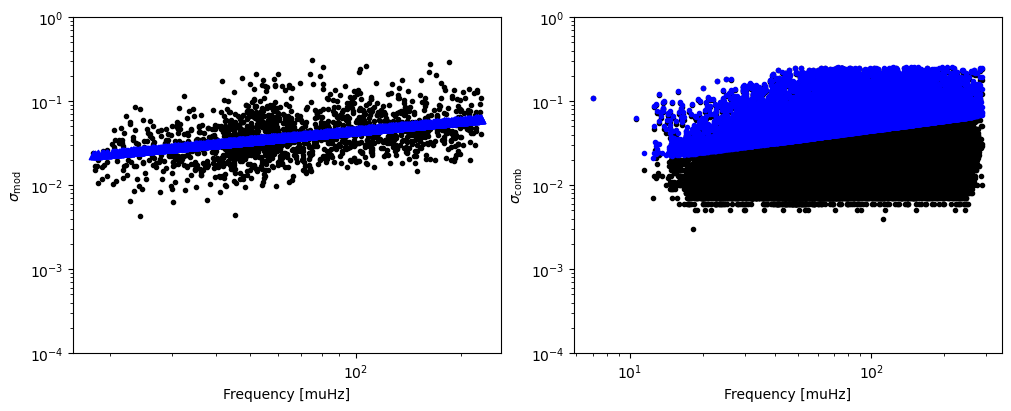

In [9]:
fig, axes = plt.subplots(figsize=(10,4), nrows=1, ncols=2, squeeze=False, constrained_layout=True)
axes=axes.reshape(-1)

idx = stars[['rms', 'numax']].notna().sum(axis=1) == 2 

axes[0].scatter(stars.loc[idx,'numax'], stars.loc[idx,'rms'], marker='.', c='k')
axes[0].scatter(stars.loc[idx,'numax'], stars.loc[idx,'rmsp'], marker='^', c='b')

modes['e_fc_comb'] = np.sqrt(modes['e_fc']**2. + (10.0**popt[0] * (modes['fc']/3090)**popt[1])**2.0)
axes[1].scatter(modes['fc'], modes['e_fc'], marker='.', c='k')
axes[1].scatter(modes['fc'], modes['e_fc_comb'], marker='.', c='b')

axes[0].set_ylabel('$\\sigma_{\\rm mod}$')
axes[1].set_ylabel('$\\sigma_{\\rm comb}$')

for iax in range(2):
    axes[iax].set_yscale('log')
    axes[iax].set_xscale('log')
    axes[iax].set_ylim(10**-4, 10**0)
    axes[iax].set_xlabel('Frequency [muHz]')

print('$\sigma_{\\rm mod}$'+' = {:0.4f} * (numax/3090)^{:0.4f} '.format(10.0**popt[0], popt[1]))

# Gather all eligible stellar models

In [10]:
# # load in all models first
# files = ['../models/uncalibrated/tracks_{}_{}.npy'.format(s*1000, (s+1)*1000-1) for s in range(0, 8)]
# models = pd.concat([pd.DataFrame(np.load(file, allow_pickle=True)) for file in files], ignore_index=True)

In [11]:
# # set index to enable fast lookup
# models = models.set_index(['index', 'profile_number'])

In [15]:
# gather the data into a gigantic array
def multi(inputs):
    istar, star = inputs

    filepath = 'results_gaia_nu/{:0.0f}/data.h5'.format(star['KIC'])
    if not os.path.exists(filepath): return None

    # observations
    idx = (modes['KIC']==star['KIC']) & (modes['l']==0)
    Nmodes = np.sum(idx)
    obs_freq = np.array(modes.loc[idx, 'fc'])
    obs_efreq = np.array(modes.loc[idx, 'e_fc']) 
    obs_l = np.array(modes.loc[idx, 'l']) 

    a, b = [0.1775, 0.4026]
    mod_efreq_sys = 10.0**a * (star['numax']/3090)**b 
    
    # models
    data = h5py.File(filepath, 'r')

    idx = (data['surf_corr_at_numax'][:]<0) & (np.abs(data['Dnu_freq'][:]/star['Dnu']-1)<0.15) \
             & (np.abs(data['numax_scaling'][:]/star['numax']-1)<0.15) & (data['surf_a3'][:]<0) 

    # begin reduced selection
    if 1000<np.sum(idx):
        uidx = idx & (data['chi2_seismic_l0'][:]<np.percentile(data['chi2_seismic_l0'][idx],1000/np.sum(idx)*100))
    else:
        uidx = idx & (data['chi2_seismic_l0'][:]<np.percentile(data['chi2_seismic_l0'][idx],100))
    idx = uidx
    # end reduced selection

    Nmodels = np.sum(idx)
    g = data['star_mass'][idx]/data['radius'][idx]**2.0
    Teff = data['Teff'][idx]
    feh = data['FeH'][idx]
    chi2_nonseis = data['chi2_classical'][idx]
    chi2 = data['chi2'][idx]

    numax_scaling = data['numax_scaling'][idx]
    numax_obs = np.zeros(np.sum(idx))+star['numax']

    Dnu_freq = data['Dnu_freq'][idx]

    Yinit = data['Yinit'][idx] 
    amlt = data['amlt'][idx]
    fov_core = data['fov_core'][idx] 
    fov_shell = data['fov_shell'][idx]
    
    mod_freqs = np.zeros((Nmodels, Nmodes))
    mod_inertias = np.zeros((Nmodels, Nmodes))
    
    indices = data['index'][idx]
    profiles = data['profile_number'][idx]

    for imod in range(Nmodels):
        if (indices[imod], profiles[imod]) in models.index :
            model = models.loc[(indices[imod], profiles[imod])]

            mod_freq = model['mode_freq']
            mod_l = model['mode_l']
            mod_inertia = model['mode_inertia']

            _, _, _, mode_freq_matched, mode_l_matched, mode_inertia_matched = match_modes(obs_freq, obs_efreq, obs_l, mod_freq, mod_l, mod_inertia)

            mod_freqs[imod, :] = mode_freq_matched
            mod_inertias[imod, :] = mode_inertia_matched
    
    idx = mod_freqs[:, 0] != 0
    Nmodels = np.sum(idx)
    
    # print('Processing KIC {:09.0f}, Nmodel: {:0.0f}'.format(star['KIC'], np.sum(idx)))

    datacube = {'istar':istar, 'KIC':star['KIC'], 'Nmodels':Nmodels, 
                'Nmodes':Nmodes, 'mod_efreq_sys':mod_efreq_sys,
                'obs_freq':obs_freq, 'obs_efreq':obs_efreq,
                'g':g[idx], 'Teff':Teff[idx], 'feh':feh[idx], 'chi2_nonseis':chi2_nonseis[idx], 'chi2':chi2[idx],
                'numax_obs':numax_obs[idx], 'numax_scaling':numax_scaling[idx], 
                'Dnu_freq':Dnu_freq[idx], 
                'Yinit':Yinit[idx], 'amlt':amlt[idx], 'fov_core':fov_core[idx], 'fov_shell':fov_shell[idx],
                'mod_freqs':mod_freqs[idx,:], 'mod_inertias':mod_inertias[idx,:]}
    return datacube 


r=process_map(multi, stars.iterrows(), total=len(stars), max_workers=12)
r = np.array(r, dtype=object) 
data_to_save = r[~(r == None)]

np.save('data/stellar_models_for_surface_optimisation', data_to_save)

  0%|          | 0/2785 [00:00<?, ?it/s]

# Fit the surface correction using the prescription

In [17]:
import jax.numpy as jnp
import jax
import numpy as np
from tqdm import tqdm
import scipy.interpolate

In [18]:
stardata = np.load('../data/stellar_models_for_surface_optimisation.npy', allow_pickle=True)
Nmodels = np.array([stardata[istar]['Nmodels'] for istar in range(len(stardata))])
minchi2 = np.array([np.min(stardata[istar]['chi2']) for istar in range(len(stardata))])
stardata = stardata[ (minchi2<20) & (Nmodels == 1000)]
# stardata = stardata[Nmodels]
np.random.seed(0)
stardata = np.random.choice(stardata, size=500, replace=False)
Nstars = len(stardata)

In [19]:
Nmodes_max = np.max([stardata[istar]['Nmodes'] for istar in range(Nstars)])
Nmodels_max = np.max([stardata[istar]['Nmodels'] for istar in range(Nstars)])
chi2s_nonseis = np.zeros((Nmodels_max, Nstars))+np.nan 
gravs, Teffs, fehs, numaxs = [np.zeros((Nmodels_max, Nmodes_max, Nstars))+np.nan for i in range(4)]

fs, gs, fs_d, gs_d  = [np.zeros((Nmodels_max, Nmodes_max, Nstars))+np.nan for i in range(4)]
 # = np.zeros((Nmodels_max, Nmodes_max, Nstars)) #for i in range(1)
obs_freq_data, mod_freq_data, obs_efreq_data, mod_inertia_data, mod_efreq_sys = [np.ones((Nmodels_max, Nmodes_max, Nstars)) for i in range(5)]

Nmodes_imod_istar = np.ones((Nmodels_max, Nstars))

idxf = np.zeros(Nstars, dtype=bool)

# rmodels = np.zeros(Nmodels_max, Nstars)+np.nan
for istar in tqdm(range(Nstars)):
    Nmodes = stardata[istar]['Nmodes']
    Nmodels = stardata[istar]['Nmodels']
    mod_freq_data[0:Nmodels,0:Nmodes,istar] = stardata[istar]['mod_freqs'][:,:]
    mod_inertia_data[0:Nmodels,0:Nmodes,istar] = stardata[istar]['mod_inertias'][:,:]
    chi2s_nonseis[0:Nmodels,istar] = stardata[istar]['chi2_nonseis']
    for imod in range(Nmodels):
        obs_freq_data[imod,0:Nmodes,istar] = stardata[istar]['obs_freq']
        obs_efreq_data[imod,0:Nmodes,istar] = stardata[istar]['obs_efreq'] #np.ones(len(stardata[istar]['obs_freq'])) # 
        mod_efreq_sys[imod,0:Nmodes,istar] = stardata[istar]['mod_efreq_sys']
        
        # # make sure numax and 1.05 numax are within freq ranges
        # fmin, fmax = np.min(stardata[istar]['mod_freqs'][imod,:]), np.max(stardata[istar]['mod_freqs'][imod,:])
        # if (fmin<(stardata[istar]['numax_scaling'][imod]+0.1)<fmax) & (fmin<(stardata[istar]['numax_scaling'][imod]-0.1)<fmax):
        #     pass
        # else:
        #     continue
            
        fi = scipy.interpolate.interp1d(stardata[istar]['mod_freqs'][imod,:], 
              (stardata[istar]['mod_freqs'][imod,:]/stardata[istar]['numax_scaling'][imod])**3.0/stardata[istar]['mod_inertias'][imod,:], 
              kind='cubic', fill_value='extrapolate')
        gs[imod,:,istar] = fi(stardata[istar]['numax_scaling'][imod])
        # gs_d[imod,:,istar] = (fi(stardata[istar]['numax_scaling'][imod]+0.01) - fi(stardata[istar]['numax_scaling'][imod]-0.01) )/ (0.02)
        
        fi = scipy.interpolate.interp1d(stardata[istar]['mod_freqs'][imod,:], 
              (stardata[istar]['mod_freqs'][imod,:]/stardata[istar]['numax_scaling'][imod])**-1.0/stardata[istar]['mod_inertias'][imod,:], 
              kind='cubic', fill_value='extrapolate')
        fs[imod,:,istar] = fi(stardata[istar]['numax_scaling'][imod])
        # fs_d[imod,:,istar] = (fi(stardata[istar]['numax_scaling'][imod]+0.01) - fi(stardata[istar]['numax_scaling'][imod]-0.01) )/ (0.02)
        
        gravs[imod,:,istar] = stardata[istar]['g'][imod]
        Teffs[imod,:,istar] = stardata[istar]['Teff'][imod]
        fehs[imod,:,istar] = stardata[istar]['feh'][imod]
        numaxs[imod,:,istar] = stardata[istar]['numax_scaling'][imod]
        
    Nmodes_imod_istar[:, istar] = Nmodes
    idxf[istar] = np.sum(np.isfinite(gravs[:,:,istar]))
    
gravs, Teffs, fehs, numaxs = gravs[:,:,idxf], Teffs[:,:,idxf], fehs[:,:,idxf], numaxs[:,:,idxf]
fs, gs = fs[:,:,idxf], gs[:,:,idxf]
# fs_d, gs_d = fs_d[:,:,idxf], gs_d[:,:,idxf]
obs_freq_data, obs_efreq_data = obs_freq_data[:,:,idxf], obs_efreq_data[:,:,idxf]
mod_freq_data, mod_inertia_data = mod_freq_data[:,:,idxf], mod_inertia_data[:,:,idxf]
chi2s_nonseis = chi2s_nonseis[:,idxf]
weight_seis = 1. # 1/10.
weight_nonseis = 1.

100%|██████████| 500/500 [00:47<00:00, 10.55it/s]


In [20]:
mod_freq_data.shape, gravs.shape  # Nmodels_max, Nmodes_max, Nstars

((1000, 10, 500), (1000, 10, 500))

In [21]:
# make everything jax
mod_freq_data = jnp.asarray(mod_freq_data)
numaxs = jnp.asarray(numaxs)
mod_inertia_data = jnp.asarray(mod_inertia_data)
obs_freq_data = jnp.asarray(obs_freq_data)

Teffs = jnp.asarray(Teffs)
gravs = jnp.asarray(gravs)
fehs = jnp.asarray(fehs)

gs = jnp.asarray(gs)
fs = jnp.asarray(fs)

In [22]:
# fitting model to be minimized
def model_linear(thetas): # use numax and scale*numax, feh
    D1 = thetas[0] * (gravs)**thetas[1] * (Teffs/5777.)**thetas[2] * (thetas[3]*fehs + 1) # surf corr at numax
    D2 = thetas[4] * (gravs)**thetas[5] * (Teffs/5777.)**thetas[6] * (thetas[7]*fehs + 1) # surf corr at scale*numax
    scale = 1.1

    surface_a3 = (scale**-1 * D1 - D2)/ ((scale**-1 - scale**3) *gs)
    surface_a1 = (scale**3 * D1 - D2)/ ((scale**3 - scale**-1) *fs)
                
    dfreq = (surface_a3 * (mod_freq_data/numaxs)**3.0 + surface_a1 * (mod_freq_data/numaxs)**-1.0)/mod_inertia_data
    mod_freq_corr_data = mod_freq_data + dfreq 
    
    chi2s_seis = jnp.mean((mod_freq_corr_data-obs_freq_data)**2.0/(obs_efreq_data**2. + mod_efreq_sys**2.), 
                          axis=1,
                          where=mod_freq_data!=1.)
    # chi2s_seis = chi2s_seis/Nmodes_imod_istar
    # chi2s_seis[chi2s_seis==0.] = np.inf
    chi2 = chi2s_seis*1. + chi2s_nonseis*1.
    logP_star = jax.scipy.special.logsumexp(-chi2/2+jnp.log(1/1000), axis=0) #+ (Nstars, )
    
    return -jnp.nansum(logP_star)*2.

jit_model_linear = jax.jit(model_linear)

In [23]:
paramsInit = jnp.array([-4.22, 1.0, -8.44, -0.41, #[-4.22, 0.99, -6.44, -0.41]
                  -8.22, 1.0, -6.44, -0.41])

# test if works
print(jit_model_linear(paramsInit))

# test if grad works
print(jax.grad(jit_model_linear)(paramsInit))

2081.3682
[  58.940773  784.4238     47.578346  -90.81769    31.889938 1223.2087
   37.698547  298.62018 ]


In [14]:
thetas = paramsInit
D1 = thetas[0] * (gravs)**thetas[1] * (Teffs/5777.)**thetas[2] * (thetas[3]*fehs + 1) # surf corr at numax
D2 = thetas[4] * (gravs)**thetas[5] * (Teffs/5777.)**thetas[6] * (thetas[7]*fehs + 1) # surf corr at scale*numax
scale = 1.1

surface_a3 = (scale**-1 * D1 - D2)/ ((scale**-1 - scale**3) *gs)
surface_a1 = (scale**3 * D1 - D2)/ ((scale**3 - scale**-1) *fs)

dfreq = (surface_a3 * (mod_freq_data/numaxs)**3.0 + surface_a1 * (mod_freq_data/numaxs)**-1.0)/mod_inertia_data
mod_freq_corr_data = mod_freq_data + dfreq 

chi2s_seis = jnp.mean((mod_freq_corr_data-obs_freq_data)**2.0/(obs_efreq_data**2. + mod_efreq_sys**2.), 
                      axis=1,
                      where=mod_freq_data!=1.)

In [381]:
import optax

def fit(params, optimizer):
    opt_state = optimizer.init(params)

    @jax.jit
    def step(params, opt_state):
        loss_value, grads = jax.value_and_grad(model_linear)(params)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value

    for i  in range(1000):
        params, opt_state, loss_value = step(params, opt_state)
        if i % 50 == 0:
            print(f'step {i}, loss: {loss_value}')

    return params

# Finally, we can fit our parametrized function using the Adam optimizer
# provided by optax.
optimizer = optax.adam(learning_rate=3e-2)
params = fit(paramsInit, optimizer)

step 0, loss: 2081.3681640625
step 50, loss: 1887.498779296875
step 100, loss: 1872.5123291015625
step 150, loss: 1869.916015625
step 200, loss: 1868.2257080078125
step 250, loss: 1866.802734375
step 300, loss: 1865.3685302734375
step 350, loss: 1865.23974609375
step 400, loss: 1862.8294677734375
step 450, loss: 1865.7470703125
step 500, loss: 1860.647216796875
step 550, loss: 1859.9803466796875
step 600, loss: 1858.787109375
step 650, loss: 1857.896484375
step 700, loss: 1857.03125
step 750, loss: 1857.60107421875
step 800, loss: 1855.67041015625
step 850, loss: 1854.9853515625
step 900, loss: 1854.80078125
step 950, loss: 1853.829833984375


In [379]:
params

DeviceArray([-6.1067133 ,  0.7903391 , -5.0384684 , -0.79030114,
             -7.6887097 ,  0.7891193 , -4.590981  , -0.8650327 ],            dtype=float32)

In [29]:
p = jnp.array([-6.1067133 ,  0.7903391 , -5.0384684 , -0.79030114,
             -7.6887097 ,  0.7891193 , -4.590981  , -0.8650327])

# approx uncertainties from the Hessian matrix
err = jnp.diag(jnp.abs(jnp.linalg.inv(jax.hessian(jit_model_linear)(p))))**0.5


# print((', '.join(['{:.2f}']*len(p))).format(*p))
# print((', '.join(['{:.2f}']*len(err))).format(*err))

for i in range(len(p)):
    print(f'{p[i]:.2f}'+r'\pm'+f'{err[i]:.2f}')
# print((', '.join(['{:.2f}']*len(p))).format(*p))

-6.11\pm0.28
0.79\pm0.04
-5.04\pm0.85
-0.79\pm0.09
-7.69\pm0.72
0.79\pm0.03
-4.59\pm0.68
-0.87\pm0.08


# Get new models with the corrected frequencies

In [12]:
grids = pd.read_csv('../../hpc/coarse_v5/template/coarse_grid_input_params_v5.txt') 

In [13]:
grids.describe()

,index,star_mass,Xinit,Yinit,Zinit,amlt,fov_shell,fov0_shell,fov_core,fov0_core
count,32768.000000,32768.000000,32768.000000,32768.000000,32768.000000,32768.000000,32768.000000,32768.000000,32768.000000,32768.000000
mean,16383.500000,1.500010,0.686318,0.300003,0.013679,2.000003,0.004000,0.002000,0.010000,0.005000
std,9459.451147,0.461887,0.041481,0.040415,0.012292,0.404151,0.002309,0.001155,0.005774,0.002887
min,0.000000,0.700050,0.587882,0.230006,0.001446,1.300021,0.000000,0.000000,0.000000,0.000000
25%,8191.750000,1.100032,0.651764,0.265004,0.003770,1.650005,0.002000,0.001000,0.005000,0.002500
50%,16383.500000,1.500015,0.686086,0.300002,0.008866,1.999989,0.004000,0.002000,0.009999,0.005000
75%,24575.250000,1.899998,0.720430,0.335000,0.020672,2.349973,0.006000,0.003000,0.014999,0.007500
max,32767.000000,2.299980,0.767876,0.369998,0.051632,2.699957,0.008000,0.004000,0.019999,0.010000


In [98]:
from tqdm import tqdm
import astropy.table
from grid import get_model_Dnu
import scipy.interpolate

# for i in range(0, 17): #range(15, 17)
def multi(inputs):
    
    i = inputs
    start = i*1000
    end = (i+1)*1000-1 if (i+1)*1000-1 < (2**14) else 2**14
    sl = slice(start, end, 1)
    print(sl)
    
    tracks = []
    for it, track in tqdm(grids.loc[sl,:].iterrows(), total=1000):
        filepath = '../hpc/coarse_v5/pre_rgb_tip/complete_grid/index{:06.0f}.history.h5'.format(track['index'])
        if not os.path.exists(filepath): continue

        cols = ['index', 'profile_number', 'flag_seismo', 
                'Yinit', 'Xinit', 'Zinit', 'fov_core', 'fov_shell', 'amlt', 
                'star_age', 'star_mass', 'luminosity', 'radius', 'Teff', 
                'log_g', 'FeH', 'delta_nu_scaling', 'numax_scaling', 'acoustic_cutoff']

        f = h5py.File(filepath, 'r')
        # print(filepath)
        cols = ['index', 'profile_number', 'flag_seismo', 
                'star_age', 'star_mass', 'luminosity', 'radius', 'Teff', 'delta_nu_scaling', 'numax_scaling', 'acoustic_cutoff', 'delta_Pg', 'log_g',
                'Yinit', 'Xinit', 'Zinit', 'center_h1', 'fov_core', 'fov_shell', 'amlt', 'FeH', 'log_LHe', 'log_Lnuc']


        atrack = Table([f[col][:] for col in cols], names=cols)
        idx = (atrack['flag_seismo']==1)  & (atrack['Teff']<5500) & (atrack['numax_scaling']>15) & (atrack['numax_scaling']<300) & \
            ((atrack['delta_nu_scaling']/(atrack['numax_scaling']**2.0 * atrack['delta_Pg'] * 1e-6))>3.5) & ((atrack['log_LHe']-atrack['log_Lnuc'])<-3)

        atrack = atrack[idx]
        atrack['density'] = atrack['star_mass']**0.5/atrack['radius']**-1.5
        atrack['numax'] = atrack['numax_scaling']
        atrack['Dnu'] = atrack['delta_nu_scaling']

        atrack['[M/H]'] = atrack['FeH']
        atrack['mode_l'] = np.zeros(len(atrack), dtype=object)
        atrack['mode_n'] = np.zeros(len(atrack), dtype=object)
        atrack['mode_freq'] = np.zeros(len(atrack), dtype=object)
        atrack['mode_inertia'] = np.zeros(len(atrack), dtype=object)
        
        # # # replace the acoustic_cutoff from mesa with numax_scaling
        atrack['acoustic_cutoff'] = atrack['numax_scaling']
        atrack['Dnu_freq_o'] = np.zeros(len(atrack))
        atrack['eps_o'] = np.zeros(len(atrack))
        atrack['surf_corr_at_numax'] = np.zeros(len(atrack))
        # #
        for i in range(len(atrack)):
            # historyIndex = atrack[i]['index']
            profileIndex = atrack[i]['profile_number']

            numax_scaling = atrack[i]['numax_scaling']
            g = atrack[i]['star_mass']/atrack[i]['radius']**2.0
            Teff = atrack[i]['Teff']
            feh = atrack[i]['FeH']
            
            atrack['mode_l'][i] = f['profile{:0.0f}/{:s}'.format(profileIndex, 'l')][:][0]
            atrack['mode_n'][i] = f['profile{:0.0f}/{:s}'.format(profileIndex, 'n_pg')][:][0]
            mode_freq = f['profile{:0.0f}/{:s}'.format(profileIndex, 'freq')][:][0]
            mode_inertia = f['profile{:0.0f}/{:s}'.format(profileIndex, 'E_norm')][:][0]
            
            atrack['Dnu_freq_o'][i], atrack['eps_o'][i] = get_model_Dnu(mode_freq, atrack['mode_l'][i], \
                                                    atrack['delta_nu_scaling'][i], atrack['numax_scaling'][i], atrack['mode_n'][i])
            
            thetas = np.array([-6.185296 ,  0.7798102, -4.807426 , -0.7790131, 
                               -7.7618823,  0.7829924, -4.3983994, -0.8528419])
                
            D1 = thetas[0] * (g)**thetas[1] * (Teff/5777.)**thetas[2] * (thetas[3]*feh + 1) # surf corr at numax
            D2 = thetas[4] * (g)**thetas[5] * (Teff/5777.)**thetas[6] * (thetas[7]*feh + 1) # surf corr at scale*numax
            scale = 1.1

            fi = scipy.interpolate.interp1d(mode_freq, (mode_freq/numax_scaling)**3.0/mode_inertia, kind='cubic')
            gs = fi(numax_scaling)

            fi = scipy.interpolate.interp1d(mode_freq, (mode_freq/numax_scaling)**-1.0/mode_inertia, kind='cubic')
            fs = fi(numax_scaling)

            surface_a3 = (scale**-1 * D1 - D2)/ ((scale**-1 - scale**3) *gs)
            surface_a1 = (scale**3 * D1 - D2)/ ((scale**3 - scale**-1) *fs)
            dfreq = (surface_a3 *(mode_freq/numax_scaling)**3.0+surface_a1 *(mode_freq/numax_scaling)**-1.0)/mode_inertia
            
            atrack['mode_freq'][i] = mode_freq + dfreq
            atrack['mode_inertia'][i] = mode_inertia
            atrack['surf_corr_at_numax'][i] = D1
            
        tracks.append(atrack)
        
    data = astropy.table.vstack(tracks)
    np.save('tracks_{:0.0f}_{:0.0f}'.format(sl.start, sl.stop), data)
    
from multiprocessing import Pool

if __name__ == '__main__':
    with Pool(8) as p:
        print(p.map(multi, range(0, 17))) #[11, 12, 13, 14, 15, 16]

slice(0, 999, 1)
slice(1000, 1999, 1)slice(2000, 2999, 1)slice(3000, 3999, 1)slice(5000, 5999, 1)slice(4000, 4999, 1)slice(6000, 6999, 1)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

slice(7000, 7999, 1)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]/suphys/yali4742/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/suphys/yali4742/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/suphys/yali4742/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/suphys/yali4742/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/suphys/yali4742/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/suphys/yali4742/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide
/suphys/yali4742/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in

slice(8000, 8999, 1)


 93%|█████████▎| 927/1000 [13:09<01:38,  1.36s/it]

slice(9000, 9999, 1)


 72%|███████▏  | 720/1000 [13:17<05:47,  1.24s/it]

slice(10000, 10999, 1)


  5%|▌         | 51/1000 [00:44<21:37,  1.37s/it]]

slice(11000, 11999, 1)


 98%|█████████▊| 980/1000 [14:31<00:24,  1.25s/it]

slice(12000, 12999, 1)


 83%|████████▎ | 826/1000 [15:06<03:19,  1.14s/it]

slice(13000, 13999, 1)


 30%|██▉       | 298/1000 [04:52<21:55,  1.87s/it]

slice(14000, 14999, 1)


 30%|███       | 300/1000 [04:55<18:20,  1.57s/it]

slice(15000, 15999, 1)


 94%|█████████▍| 945/1000 [14:17<01:05,  1.20s/it]

slice(16000, 16384, 1)


100%|██████████| 1000/1000 [17:27<00:00,  1.05s/it]


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [39]:

from grid import grid

In [40]:
grid.get_model_Dnu?

Signature: grid.get_model_Dnu(mod_freq, mod_l, Dnu, numax, mod_n=None)
Docstring:
Calculate model Dnu around numax, by fitting freq vs n with 
Gaussian envelope around numax weighted data points, or with
observational uncertainty weighted data points (if obs_freq, 
obs_efreq and obs_l are set).

----------
Input:
mod_freq: array_like[Nmode_mod]
    model's mode frequency
mod_l: array_like[Nmode_mod]
    model's mode degree
Dnu: float
    the p-mode large separation in muHz
numax: float
    the frequency of maximum power in muHz

----------
Optional input:
obs_freq: array_like[Nmode_obs]
    observation's mode frequency
obs_efreq: array_like[Nmode_obs]
    observation's mode frequency uncertainty
obs_l: array_like[Nmode_obs]
    observation's mode degree

----------
Return:
mod_Dnu: float
File:      ~/OneDrive/github/grid/grid/src/Dnu.py
Type:      function

In [53]:
# d = pd.read_parquet('/Users/yaguang/modelbase/rgb-pi-modes/models/index0_999.parquet')

In [58]:
d.iloc[10]['E_norm']

array([4.79607207e-05, 1.01756964e-05, 3.57808839e-06, 1.65928252e-06,
       8.90857325e-07, 6.55947842e-07, 5.32283687e-07, 4.52272062e-07,
       4.25712172e-07, 4.16941335e-07, 4.14743598e-07, 4.25235489e-07,
       4.46400538e-07, 4.85127092e-07, 2.23969503e-05, 5.87555651e-06,
       2.49847455e-06, 1.20417085e-06, 7.51754063e-07, 5.95991726e-07,
       4.87702033e-07, 4.34772641e-07, 4.20297816e-07, 4.13721659e-07,
       4.17243458e-07, 4.33148903e-07, 4.60761698e-07, 5.17986117e-07,
       6.44807744e-05, 1.29248837e-05, 4.12318298e-06, 1.87706674e-06,
       9.62823942e-07, 6.78240154e-07, 5.48452588e-07, 4.59126548e-07,
       4.26114224e-07, 4.16282369e-07, 4.12591025e-07, 4.21317625e-07,
       4.41160293e-07, 4.76599708e-07, 5.68088780e-07])